In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import statsmodels.api as sma

from sklearn.metrics import mean_squared_error, r2_score

zip_agg = pd.read_csv("E:\Group Folder\data\zip_agg_feats.csv")
# zip_agg = pd.read_csv("E:\Group Folder\data\zipcode_agg_ext_feats.csv")

In [2]:
# Fixing
# zip_agg = zip_agg[zip_agg["juris_name"]!="New York"]
# zip_agg["distances"] = (zip_agg["on_vue"]/zip_agg["num_tests"])*zip_agg["distances"]
# zip_agg["out_of_state"] = np.maximum(zip_agg["out_of_state"] - zip_agg["on_vue"], 0)

In [3]:
# # Columns which indicate the resuslts of a GED test (these will be the target)
# result_cols = ["score","first_passed","first_complete",
#                "make_passed","make_complete"]

# # Wide format results
# results = zip_agg[['zipcode','exam_subject']+result_cols].pivot_table(index='zipcode',columns='exam_subject')
# # # flatten columns
# flat_cols = [col[1]+"_"+col[0] for col in results.columns]
# results.columns = flat_cols

In [4]:
flag_cols = ['first_passed', 'first_complete', 'make_passed', 'make_complete']

continuous_cols = ["score"]+["prep_time","age"]+["distances","num_candidates"]+[
    'low_income_pct', "non_college",'employment_rate','disability_pct']+[
    "race_white","race_african_american","race_asian","race_native_american"]

study_cols = ['study_helpful_adult_education_teacher',
       'study_helpful_audio_study_materials',
       'study_helpful_books_printed_study_material', 'study_helpful_ged_ready',
       'study_helpful_materials_mobile_app',
       'study_helpful_online_course_video_study_materials',
       'study_helpful_other', 'study_helpful_social_networking_website',
       'study_helpful_tv_study_program',
       'study_location_test_preparation_center']

sum_cols = ['num_tests', 'num_practice_tests',
            'on_vue', 'no_show', 'out_of_town', 'out_of_state', 'gender_MALE',
           'language_code_ESP']

mode_cols = ['studied_for_ged', 't_state', 'testing_reason',"num_test_centers",
       'juris_name', 'school_incomplete_reason', 'highest_grade_completed',]

# zip_agg_dict = {}

# for col in continuous_cols+flag_cols:
#     zip_agg_dict[col] = "mean"
    
# for col in sum_cols+study_cols:
#     zip_agg_dict[col] = sum

# for col in mode_cols:
#     zip_agg_dict[col] = lambda x: pd.Series.mode(x)[0]
    
# zip_agg = zip_agg.groupby("zipcode").agg(zip_agg_dict)

In [5]:
# Creating proportions
sum_cols.remove("num_tests")

for col in study_cols+sum_cols+["language_code_ESP"]:
    zip_agg[col] = zip_agg[col]/zip_agg['num_tests']

candidate_prop_cols = ['gender_MALE']+flag_cols

for col in candidate_prop_cols:
    zip_agg[col] = zip_agg[col]/zip_agg['num_candidates']

In [82]:
# zip_agg['candidates_per_test_center'] = zip_agg['num_candidates']/zip_agg["num_test_centers"]

In [6]:
# Factors in the test methodology or testing conditions
test_factors = ['on_vue', 'no_show', 'out_of_town', 'out_of_state', 'language_code_ESP']

# demography factors
race_cols = ["race_white","race_african_american","race_asian","race_others"] #"race_native_american" is the base
income_cols = ['low_income_pct'] # low income is our base
college_cols = ["non_college"] # college is base
gender_cols = ["gender_MALE"] # female is the base

zip_factors = ['employment_rate','disability_pct'] # Other factors influcened by a zipcode 'candidates_per_test_center'

demographic_cols = race_cols+college_cols+gender_cols+["age"]+["language_code_ESP"]+income_cols+zip_factors

In [22]:
zip_agg["low_education"] = (zip_agg["college"]<=0.5).astype(int) # 10%
# zip_agg["mid_education"] = ((zip_agg["college"]<=0.7)&(zip_agg["college"]>0.4)).astype(int) #70%
zip_agg["high_education"] = (zip_agg["college"]>0.5).astype(int) #20%

college_cols = ["low_education"]

In [26]:
# Dropping race distribution columns as we have this data from the actual table
# drop_cols = ['indian_or_alaskan', 'asian',
#        'african_american', 'race_decline', 'white', 'race_none',
#        'hawaiian_or_pacific']

# # # Removing this col as it has 98% correlation with study_helpful_adult_education_teacher
# drop_cols += ["study_helpful_adult_education_class"]

# zip_agg.drop(columns=drop_cols, inplace=True)

# Columns to be used as features (we can't use the categorical features)
feat_cols = [col for col in zip_agg 
             if col not in flag_cols+["first_try","score","race_others","zipcode",
                                        "num_tests","num_candidates","remote_cost",
                                      "college","non_college","high_education"] and zip_agg[col].dtype!="object"]

### Linear Regression
We include all the factors that are related to demographics, test environment and test preparation (the study resources columns), and try to find out the various significant factors. 

We consider the `make_passed` as the dependent variable and perform the linear regression analysis. The variables are largely divided into the three categories below:

- Significant Effects:
    - `out_of_state`: If the proportion of out_of_state candidates increases by 1%, the credential rate of the zipcode decreases by 0.135%
    - `num_practice_tests`: If the number of practice tests per candidate increases by 1, the credential rate of the zipcode increases by 4.13%
    - `prep_time`: Not sure as its negative in some cases.
    - `study_location_test_preparation_center`: If the proportion of candidates who study using this method increases by 1%, the credentiall rate decreases by 0.065%
    - `age`: If the average age in the zipcode increases by 1 year, the credential rate decreases by 0.23%
    - `gender_MALE`: If the proportion of Male candidates increases by 1% the credential rate of the zipcode decreases by 0.04%
    - `study_helpful_ged_ready`: If the proportion of candidates who study using this method increases by 1%, the credentiall rate decreases by 0.042%.
    - `on_vue`: If the proportion of candidates who give the test remotely  increases by 1%, the credentiall rate decreases by 0.29%
    - `study_helpful_other, study_helpful_books_printed_study_material, study_helpful_online_course_video_study_materials study_helpful_materials_mobile_app, study_helpful_audio_study_materials`: All these methods have a small but significant negative effect.
    
- Insignificant Factors: Race, Income, Education distribution of a zip code is not a significant factor in predicting the credential rate of a certain zip code.

In [27]:
def perform_linear_regression_analysis(subject_name="all", 
                                        target_col="make_passed",
                                      features=feat_cols,
                                      verbose=True):
    if subject_name=="all":
        subject_df = zip_agg
    else:
        subject_df = zip_agg[zip_agg["exam_subject"]==subject_name]
    # 10 zip codes have missing acs data
    subject_df = subject_df.dropna()
    y = subject_df[target_col]
    
    # Adding constants (for beta 0)
    subject_df["constant"] = 1
    features.append("constant")
    reg  = sma.OLS(y, subject_df[features], hasconst=True)
    model = reg.fit()

    col_array = np.array(features)
    # Sorting columns in reverse order of their significance
    col_array = col_array[np.argsort(model.pvalues)][::-1]

    # adding the columns and their p-values to the dict
    feat_imp = dict(zip(col_array,np.sort(model.pvalues)[::-1]))

    # Model beta coefficients
    predictor_coeffs = dict(zip(features, model.params))
    if verbose:
        print(model.summary())
    return feat_imp, predictor_coeffs

In [28]:
feat_imp, predictor_coeffs = perform_linear_regression_analysis(subject_name="all",
                                                                target_col="make_passed",
                                                                features=feat_cols,
                                                               verbose=True)

                            OLS Regression Results                            
Dep. Variable:            make_passed   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     68.44
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:34:17   Log-Likelihood:                 2377.9
No. Observations:                8286   AIC:                            -4694.
Df Residuals:                    8255   BIC:                            -4476.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [115]:
lr_df = pd.DataFrame([feat_imp, predictor_coeffs]).T.reset_index()
lr_df.columns = ["variable","p_value", "beta"]
lr_df = lr_df.sort_values("p_value")
lr_df = lr_df[lr_df["variable"]!="constant"]
lr_df[lr_df["p_value"]<0.05]

# index where variable is not a proportion --> Coeff is not in %age
abs_index = lr_df["variable"].isin(["age"])
lr_df.loc[abs_index, "beta"] = lr_df.loc[abs_index, "beta"]*100
# lr_df.loc[lr_df["variable"]=="age","beta"] = lr_df.loc[lr_df["variable"]=="age","beta"]*100

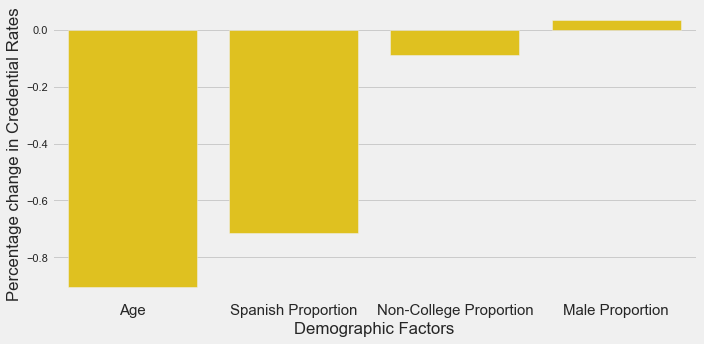

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.set_theme("notebook")
plt.style.use("fivethirtyeight")
plot_var_list = ["age", "language_code_ESP", "non_college","gender_MALE"]
bar = sns.barplot(data=lr_df.loc[lr_df["variable"].isin(plot_var_list)],
            y="beta", x="variable", color="gold")
plt.ylabel("Percentage change in Credential Rates")
plt.xlabel("Demographic Factors")

bar.set_xticklabels(["Age","Spanish Proportion", "Non-College Proportion", "Male Proportion"])
plt.xticks(rotation=0, fontsize=15)
plt.tight_layout()

### Demographic Analysis
We want to significant factors in the overall data
- Racial distribution effect: as compared to "Other" races, african american & native americans show the lowest scores relatively. While White candidates perform better.
- Age has a negative relationship
- Percentage of population with higher income also has a negative relationship
- Proportion of Male candidates has a positive relationship

In [33]:
# Correlation analysis, change target_col for analysis with a different column
target_col = "make_passed"
zip_agg[demographic_cols].corrwith(zip_agg[target_col])

race_white               0.036136
race_african_american   -0.027404
race_asian              -0.000694
race_native_american    -0.027037
high_income_pct         -0.002693
college                  0.010011
gender_MALE             -0.059129
age                     -0.071221
dtype: float64

### Test Factor Analysis
- Out of Town is insignificant, but out of state has a significant negative effect. 
    - People from different zipcodes perhaps go to a accessible test center. But traveling across state lines is much rarer.
    - Relationship with distance?
- Remote tests have a lower passing rate
- Language does not have a significant effect

In [68]:
# Correlation analysis, change target_col for analysis with a different column
zip_agg[test_factors].corrwith(zip_agg[target_col])

on_vue               0.047457
no_show                   NaN
out_of_town          0.000862
out_of_state        -0.094381
language_code_ESP   -0.012224
dtype: float64

In [30]:
feat_imp, predictor_coeffs = perform_linear_regression_analysis(subject_name="all",
                                                                target_col="first_passed",
                                                                features=test_factors)

                            OLS Regression Results                            
Dep. Variable:           first_passed   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.098
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           0.000422
Time:                        18:24:52   Log-Likelihood:                 4125.7
No. Observations:                9387   AIC:                            -8241.
Df Residuals:                    9382   BIC:                            -8206.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
on_vue               -0.1353      0.05

### Study Factors
- GED Ready Programs, Online Video Study Materials are the most helpful.
- Mobile app has the most negative effect (p-value=5.5%)

In [31]:
study_factors = ['study_helpful_adult_education_teacher',
       'study_helpful_audio_study_materials',
       'study_helpful_books_printed_study_material', 'study_helpful_ged_ready',
       'study_helpful_materials_mobile_app',
       'study_helpful_online_course_video_study_materials',
       'study_helpful_other', 'study_helpful_social_networking_website',
       'study_helpful_tv_study_program',
       'study_location_test_preparation_center']

In [32]:
# Correlation analysis, change target_col for analysis with a different column
target_col = "first_passed"
zip_agg[study_factors].corrwith(zip_agg[target_col])

study_helpful_adult_education_teacher               -0.027296
study_helpful_audio_study_materials                  0.041650
study_helpful_books_printed_study_material           0.012854
study_helpful_ged_ready                              0.188878
study_helpful_materials_mobile_app                   0.021055
study_helpful_online_course_video_study_materials    0.129196
study_helpful_other                                 -0.005079
study_helpful_social_networking_website              0.036988
study_helpful_tv_study_program                       0.010128
study_location_test_preparation_center               0.039019
dtype: float64

In [33]:
feat_imp, predictor_coeffs = perform_linear_regression_analysis(subject_name="all",
                                                                target_col="first_passed",
                                                                features=study_factors)

                            OLS Regression Results                            
Dep. Variable:           first_passed   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     44.74
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           1.12e-87
Time:                        18:26:00   Log-Likelihood:                 4334.2
No. Observations:                9387   AIC:                            -8646.
Df Residuals:                    9376   BIC:                            -8568.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------